In [2]:
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"
%pip install -q "openvino>=2023.1.0"
%pip install -q --upgrade-strategy eager "diffusers>=0.18.0" "invisible-watermark>=0.2.0" "transformers>=4.30.2" "accelerate" "onnx" "onnxruntime"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline, OVStableDiffusionXLPipeline
from pathlib import Path

In [4]:
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
model_dir = Path("openvino-sd-xl-base-1.0")

In [8]:
if not model_dir.exists():
    base = OVStableDiffusionXLPipeline.from_pretrained(model_id, compile=False, device='CPU')
    base.half()
    base.save_pretrained(model_dir)
    base.compile()
else:
    base = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder_2...
Compiling the text_encoder...
Compiling the vae_encoder...


In [33]:
import numpy as np

prompt = "Astronaut in a desert, hot color palette, muted colors, detailed, 8k"
latents = base(prompt, num_inference_steps=15, height=512, width=512, output_type="latent").images[0]

  0%|          | 0/15 [00:00<?, ?it/s]

In [34]:
refiner_model_id = "stabilityai/stable-diffusion-xl-refiner-1.0"
refiner_model_dir = Path("openvino-sd-xl-refiner-1.0")

if not refiner_model_dir.exists():
    refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_id, export=True, compile=False)
    refiner.half()
    refiner.save_pretrained(refiner_model_dir)
    del refiner

In [35]:
refiner = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_dir, device='CPU')

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder_2...
Compiling the vae_encoder...


  0%|          | 0/3 [00:00<?, ?it/s]

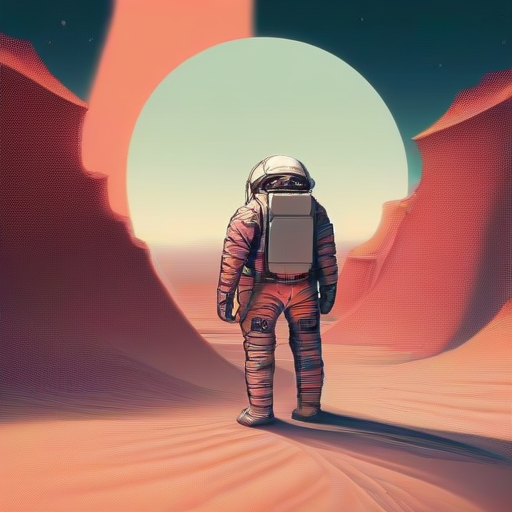

In [36]:
image = refiner(prompt=prompt, image=np.transpose(latents[None, :], (0, 2, 3, 1)), num_inference_steps=10).images[0]
image.save("cat_refined.png")

image